In [ ]:
%load_ext autoreload
%autoreload 2

## Loading the PBSIM data

In [3]:
filepath = r"C:\Users\Parv\Doc\RA\Projects\incomplete_cycles\PBSIM-PacBio-Simulator"

In [4]:

import os
from utils import get_reference_from_file, read_strands_from_file, read_strands_from_file_alt

sequenced_strands = {}
collected_files = set()

for file in os.listdir(filepath):
    if file[:2] == "sd":
        
        filename = file[:7]

        if filename in collected_files:
            continue

        collected_files.add(filename)

        ref_file = os.path.join(filepath, filename + ".ref")
        fastq_file = os.path.join(filepath, filename + ".fastq")

        ref = get_reference_from_file(ref_file)
        strands = read_strands_from_file_alt(fastq_file)
        sequenced_strands[ref] = strands
        print(f"Collected {ref}")
            

Collected 3823f37c-5239-4e40-b79a-8caa179b47c3
Collected 690ce148-f0f9-4fc9-9922-7cc16baaea4b
Collected 517665dd-57a1-4d11-9541-bc974c35f26a
Collected a7edd81c-9a09-4b79-80f2-2130d743e826
Collected e8586e97-2d2a-4f41-aca7-35c01751a34b
Collected 1fde53d1-385d-480c-bb71-1f3d5f2c9134
Collected 65a564b4-d90c-4951-9597-10f959945fd1
Collected b415ef82-22f4-4766-a72c-5e7bd4e02067
Collected 40879282-30a5-4d49-a576-efe8e7ac9b4a
Collected 8608e1a7-e85e-4b14-88fa-f42d49c700e5
Collected 9effc92e-7a87-4dfe-a733-c0aafdf0e4de
Collected 9caea68c-1585-4014-8e2b-a33a56021eea
Collected a97ba880-e506-4568-a90d-e2709740482a
Collected 6e83438f-d9b5-4110-90dc-e2aa6d793c57
Collected 47d364f5-b3bf-40a4-ab69-54e778720509
Collected eeac40a1-8706-43f0-9032-07e4f92ef358
Collected 9f137acd-4442-4b91-a7bb-db7bc61f3f17
Collected aac59dd2-f3e1-4169-9979-aae00d5bf408
Collected e95da740-9e9c-4aa8-ac20-7cc2186d1262
Collected 93490b4b-cd1a-4923-aa41-200d4ed30599
Collected 4744206d-4960-4510-8159-38a6ebd97fe0
Collected 71d

### Testing the different methods

### Aligned Clustering

In [ ]:
from aligned_clustering import conduct_align_clustering
from creating_synthesized_strands_from_strands import get_original_strands
import time

ids, coupling_rates, capping_flags, original_strands = get_original_strands()

recovery_percentages = []

coupling_rate_counter = 0
prev_coupling_rate = 9
max_iterations_per_cr = 100
repeats_per_file = 1

for label, coupling_rate, capping_flag in (zip(ids, coupling_rates, capping_flags)):

    # Controlling repeats
    if coupling_rate == prev_coupling_rate:
        if coupling_rate_counter >= max_iterations_per_cr:
            continue
        coupling_rate_counter += 1
    else:
        coupling_rate_counter = 0
        prev_coupling_rate = coupling_rate

    print(f"{label} {coupling_rate} {capping_flag}")
    sequenced_strand_repeats = sequenced_strands[label]
    original_strand  = original_strands[label]
    
    startime = time.time()

    # Testing the clustering
    max_rec = 0
    for repeats in range(repeats_per_file):

        recovery_dict = conduct_align_clustering(
            original_strand=original_strand,
            trimmed_seqs=sequenced_strand_repeats,
            display=False
        ) 
        
        recovery_percentage = max(recovery_dict['recoveries'])
        print(recovery_percentage)
        if recovery_percentage > max_rec:
            max_rec = recovery_percentage
    
    print(max_rec)
    recovery_percentages.append(max_rec)
    
   



3823f37c-5239-4e40-b79a-8caa179b47c3 8 True
0.525
0.525
690ce148-f0f9-4fc9-9922-7cc16baaea4b 8 False
0.42
0.42
517665dd-57a1-4d11-9541-bc974c35f26a 8 True
0.37
0.37
a7edd81c-9a09-4b79-80f2-2130d743e826 8 False
0.325
0.325
e8586e97-2d2a-4f41-aca7-35c01751a34b 8 True
0.405
0.405
1fde53d1-385d-480c-bb71-1f3d5f2c9134 8 False
0.34
0.34
65a564b4-d90c-4951-9597-10f959945fd1 8 True
0.46
0.46
b415ef82-22f4-4766-a72c-5e7bd4e02067 8 False
0.375
0.375
40879282-30a5-4d49-a576-efe8e7ac9b4a 8 True
0.375
0.375
8608e1a7-e85e-4b14-88fa-f42d49c700e5 8 False
0.455
0.455
9effc92e-7a87-4dfe-a733-c0aafdf0e4de 8 True
0.375
0.375
9caea68c-1585-4014-8e2b-a33a56021eea 8 False
0.37
0.37
a97ba880-e506-4568-a90d-e2709740482a 8 True
0.345
0.345
6e83438f-d9b5-4110-90dc-e2aa6d793c57 8 False
0.37
0.37
47d364f5-b3bf-40a4-ab69-54e778720509 8 True
0.375
0.375
eeac40a1-8706-43f0-9032-07e4f92ef358 8 False
0.485
0.485
9f137acd-4442-4b91-a7bb-db7bc61f3f17 8 True
0.37
0.37
aac59dd2-f3e1-4169-9979-aae00d5bf408 8 False
0.385
0.3

KeyboardInterrupt: 

### Otras metodos

In [23]:
from creating_synthesized_strands_from_strands import get_original_strands
from sequencing import NaiveSequencingModel
import time
from tqdm.notebook import tqdm
from utils import get_recovery_percentage
from seq_stat import cluster_seq


ids, coupling_rates, capping_flags, original_strands = get_original_strands()
recovery_rates = {}

data_str = {}

coupling_rates = [float(i) for i in coupling_rates]
capping_flags = [eval(i) for i in capping_flags]


data_str = {
    coupling_rate: {"capping": [], "no_capping": []} for coupling_rate in coupling_rates}

In [ ]:

# Creating data string indexed by coupling rates and capping and no capping
 
for label, coupling_rate, capping_flag in (zip(ids, coupling_rates, capping_flags)):

    if capping_flag:
        data_str[coupling_rate]['capping'].append(label)
    else:
        data_str[coupling_rate]['no_capping'].append(label)



In [ ]:

from random import sample
import numpy as np

coupling_rates_ = [8.0, 8.5, 9.0, 9.5, 9.9]

files_per_cr = 5

def run_simulation(sequenced_strand_repeats, original_strand, repeats=1):

    recoveries_per_repeat = []
    for _ in range(repeats):

        recovery_dict = conduct_align_clustering(
            original_strand=original_strand,
            trimmed_seqs=sequenced_strands_repeats,
            display=False
        )
        recoveries_per_repeat.append(max(recovery_dict['recoveries']))

    return recoveries_per_repeat
    
for coupling_rate in coupling_rates_:

    # Getting the ids for capped and no capped
    capped_ids = data_str[coupling_rate]['capping']
    no_capped_ids = data_str[coupling_rate]['no_capping']

    # Sampling files
    capped_ids = sample(capped_ids, files_per_cr)
    no_capped_ids = sample(no_capped_ids, files_per_cr)
    
    capping_flag = False
    if capping_flag:

        for capped_id in capped_ids:
            sequenced_strands_repeats = sequenced_strands[capped_id]
            original_strand = original_strands[capped_id]
            recoveries_per_repeat = run_simulation(
                sequenced_strand_repeats=sequenced_strand_repeats,
                original_strand=original_strand,
                repeats=10
            )
            print(recoveries_per_repeat)

    for no_capped_id in no_capped_ids:
        sequenced_strands_repeats = sequenced_strands[no_capped_id]
        original_strand = original_strands[no_capped_id]
        recoveries_per_repeat = run_simulation(
            sequenced_strand_repeats=sequenced_strand_repeats,
            original_strand=original_strand,
            repeats=10
        )
        print(recoveries_per_repeat)

        
    break




[autoreload of tqdm.utils failed: Traceback (most recent call last):
  File "C:\Users\Parv\AppData\Roaming\Python\Python39\site-packages\IPython\extensions\autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Parv\AppData\Roaming\Python\Python39\site-packages\IPython\extensions\autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Users\Parv\AppData\Roaming\Python\Python39\site-packages\IPython\extensions\autoreload.py", line 377, in update_generic
    update(a, b)
  File "C:\Users\Parv\AppData\Roaming\Python\Python39\site-packages\IPython\extensions\autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "C:\Users\Parv\AppData\Roaming\Python\Python39\site-packages\IPython\extensions\autoreload.py", line 303, in update_instances
    ref.__class__ = new
  File "c:\Users\Parv\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\utils.py", line 143, in __setattr__
    return set

  0%|          | 0/10 [00:00<?, ?it/s]

[0.475, 0.46, 0.44, 0.355, 0.345, 0.345, 0.345, 0.4, 0.36, 0.37]
[0.37, 0.37, 0.38, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.4]
[0.4, 0.32, 0.335, 0.41, 0.415, 0.37, 0.395, 0.33, 0.315, 0.33]
[0.405, 0.405, 0.425, 0.405, 0.405, 0.405, 0.425, 0.405, 0.405, 0.405]
[0.35, 0.395, 0.39, 0.355, 0.4, 0.415, 0.345, 0.355, 0.355, 0.385]
[0.365, 0.375, 0.395, 0.385, 0.415, 0.42, 0.365, 0.355, 0.365, 0.365]


KeyboardInterrupt: 

### Evaluation

In [76]:
len(recovery_percentages)

35

In [86]:
recovery_percentages

[0.355,
 0.56,
 0.425,
 0.355,
 0.5,
 0.455,
 0.375,
 0.455,
 0.435,
 0.365,
 0.39,
 0.39,
 0.43,
 0.4,
 0.555,
 0.42,
 0.365,
 0.345,
 0.385,
 0.4,
 0.43,
 0.61,
 0.415,
 0.355,
 0.515,
 0.375,
 0.485,
 0.415,
 0.41,
 0.37,
 0.325,
 0.47,
 0.505,
 0.545,
 0.4]

In [97]:

coupling_rates_unique = np.unique([float(i) for i in coupling_rates])

recovery_capping = {coupling_rate: [] for coupling_rate in coupling_rates_unique}
recovery_no_capping = {coupling_rate: [] for coupling_rate in coupling_rates_unique}

for j in range(len(coupling_rates_unique)):
    for i in range(max_iterations_per_cr):
        try:
            recovery_capping[coupling_rates_unique[j]].append(recovery_percentages[j * max_iterations_per_cr + (2*i)])
            recovery_no_capping[coupling_rates_unique[j]].append(recovery_percentages[j * max_iterations_per_cr + (2*i + 1)])
        except Exception as e:
            print(e)
            print(j, i)


In [98]:
recovery_capping

{8.0: [0.665, 0.43],
 8.25: [0.43, 0.47],
 8.5: [0.47, 0.455],
 8.75: [0.455, 0.46],
 9.0: [0.46, 0.4],
 9.25: [0.4, 0.395],
 9.5: [0.395, 0.45],
 9.75: [0.45, 0.595],
 9.99: [0.595, 0.69]}

In [99]:
means_capping = [np.mean(recovery_capping[i]) for i in recovery_capping.keys()]
print(means_capping)

[0.5475, 0.44999999999999996, 0.4625, 0.4575, 0.43000000000000005, 0.3975, 0.4225, 0.5225, 0.6425]


In [100]:
means_no_capping = [np.mean(recovery_no_capping[i]) for i in recovery_capping.keys()]
print(means_no_capping)

[0.525, 0.44, 0.3625, 0.395, 0.525, 0.5075000000000001, 0.4625, 0.485, 0.435]


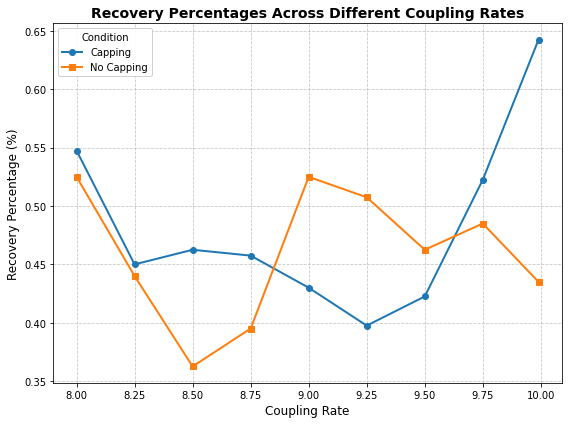

In [105]:
import matplotlib.pyplot as plt

# Plot with markers, line styles, and refined aesthetics
plt.figure(figsize=(8, 6))  # Increase figure size for clarity

# Plot with custom colors, markers, and line thickness
plt.plot(coupling_rates_unique, means_capping, marker='o', linestyle='-', color='#1f77b4', linewidth=2, markersize=6, label='Capping')
plt.plot(coupling_rates_unique, means_no_capping, marker='s', linestyle='-', color='#ff7f0e', linewidth=2, markersize=6, label='No Capping')

# Titles and labels with larger fonts
plt.title("Recovery Percentages Across Different Coupling Rates", fontsize=14, fontweight='bold')
plt.xlabel("Coupling Rate", fontsize=12)
plt.ylabel("Recovery Percentage (%)", fontsize=12)

# Adding a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Customize legend
plt.legend(title="Condition", title_fontsize=10, fontsize=10, loc='best', frameon=True, framealpha=0.9)

# Show plot
plt.tight_layout()  # Adjust layout to prevent label cut-off
plt.show()


In [30]:
import numpy as np

recovery_rates_capping_means = {i : np.mean(recovery_rates_capping[i]) for i in recovery_rates_capping.keys()}

recovery_rates_no_capping_means = {i : np.mean(recovery_rates_no_capping[i]) for i in recovery_rates_no_capping.keys()}

In [31]:
recovery_rates_capping_means

{8.0: 0.39249999999999996,
 8.25: nan,
 9.0: nan,
 8.5: nan,
 8.75: nan,
 9.25: nan,
 9.5: nan,
 9.75: nan,
 9.99: nan}

In [16]:
print("Recovery rates for capping with different coupling rates")
for key, value in recovery_rates_capping_means.items():
    print(f"{key}: {value:.2f}\n")

print("\nRecovery rates for no capping with different coupling rates")
for key, value in recovery_rates_no_capping_means.items():
    print(f"{key}: {value:.2f}\n")

Recovery rates for capping with different coupling rates
8.0: 0.31

8.25: 0.31

9.0: 0.32

8.5: 0.33

8.75: 0.31

9.25: 0.31

9.5: 0.32

9.75: 0.33

9.99: 0.31


Recovery rates for no capping with different coupling rates
8.0: 0.31

8.25: 0.32

9.0: 0.31

8.5: 0.30

8.75: 0.32

9.25: 0.33

9.5: 0.32

9.75: 0.31

9.99: 0.31



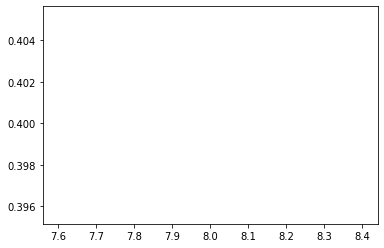

In [22]:

import matplotlib.pyplot as plt

coupling_rates_unique = list(set(coupling_rates))
plt.plot(coupling_rates_unique, recovery_rates_capping_means.values())
plt.plot(coupling_rates_unique, recovery_rates_no_capping_means.values())

plt.show()

(array([8.900e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 4.000e+00, 1.062e+03]),
 array([  1. ,  20.7,  40.4,  60.1,  79.8,  99.5, 119.2, 138.9, 158.6,
        178.3, 198. ]),
 <BarContainer object of 10 artists>)

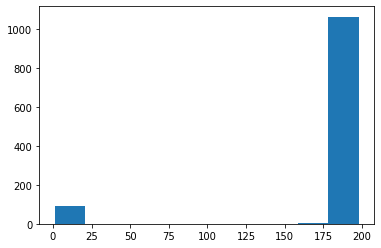

In [23]:
lens = [len(i) for i in sequenced_strand_repeats]
import matplotlib.pyplot as plt

plt.hist(lens)

In [61]:
print(consensus_strand)

CTGTCCATCTAGTTCCGGTCCCAAGAGATACGGAGACAAGAAAAACCAACTCCCAGATGTTACGCAGGGCAAAGTATATTAATTCACGTCTCATGCTCGTGTGGAGCTTTGGCGCTTGTCCCGTGTCTACGATCAGAAATGTTTGGCGCGTGGGTTACTAGGCTCGGATAAGGAAAACACCAATCTTCATCAGTGACAGC


In [62]:
print(original_strand)

CTGTCCATCTAGTTCCGGTCCCAAGAGATACGGAGACAAGAAAAACCAACTCCCAGATGTTACGCAGGGCAAAGTATATTAATTCACGTCTCATGCTCGTGTGGAGCTTTGGCGCTTGTCCCGTGTCTACGATCAGAAATGTTTGGCGCGTGGGTTACTAGGCTCGGATAAGGAAAACACCAATCTTCATCAGTGACAGC


In [63]:
from main import get_recovery_percentage

get_recovery_percentage(consensus_strand, original_strand)

1.0

In [47]:
original_strands

['CTGTCCATCTAGTTCCGGTCCCAAGAGATACGGAGACAAGAAAAACCAACTCCCAGATGTTACGCAGGGCAAAGTATATTAATTCACGTCTCATGCTCGTGTGGAGCTTTGGCGCTTGTCCCGTGTCTACGATCAGAAATGTTTGGCGCGTGGGTTACTAGGCTCGGATAAGGAAAACACCAATCTTCATCAGTGACAGC',
 'GTTCAAATTGCAACCCGGTAAAGACTGCTGGCTAACAATAAGGACACATACATGCTCCGAACGTCCCGTTTATGTCCACGAAAGGGCTGCGTTTAGACTAAGCGGTTCTGTACCCGTCTCATCCTCACGGGCGCGCTTGGGATCACTGTTTGACCTGACAGTTACGCACTAACGTGACTGGTCAATCCCTAATAGTCAGA',
 'TATTTTACTTTGTGAGTTCACATCATCCATTGCGGCGCGACGTAGGAAATCGATGATATTCAACGCCAACTCGCCCTTATACCCCCTACGGCCCATGCGTCTTTAAGATTCTGCTTTGGACGCAGGAAACTTTTTAGAATCTTCACCGAGCCGGTTAGCTTGCACACTTTCCCACGTGATGACGCTACTCGTTCTTATCA',
 'CTCACGATAATTTACTTAGGAATTGTCACCGGTCCGGAGACCCACTAAATGTTTTTAGCGGGGGCACCCACTGTCCGACTACCGCACGTTACTGGCGTAAACACCGGGGTCGCTGCCGGATCGAATCATCTTTAAAAGCCTATACGGACCTTATATGCGTGGGCACGGCAAGGCGCGTTACTTCATGGGCGTACCCCCCC',
 'AAGCTTTGTTCATAGCCCACCCCCCCCGTTATCGATGTCCTAAGTACGAGAGAGTGGGGAGGAATAAGTGCGAGCATCCAATTTCAGAAAGGACCTGCAGTTCAGCGTAGACACACGCGATGAAAAATCACGCTGAGTTCGTTCTACATCCGGGTCCAAAAAACGGTGGGTGCGCCAT

In [14]:
os.listdir()

['.ipynb_checkpoints',
 'creating_synthesis_file.py',
 'creating_synthesized_strands_from_strands.py',
 'dna_storage.py',
 'ecc.py',
 'getting_files.ipynb',
 'main.py',
 'original_strands.txt',
 'reads.txt',
 'sd_0003.fastq',
 'sd_0003.ref',
 'sd_0044.fastq',
 'sd_0044.maf',
 'sd_0044.ref',
 'sequenced_badread.txt',
 'sequencing.py',
 'seq_stat.py',
 'synthesis.py',
 'synthesized.fasta',
 'synthesized_strands.fasta',
 'synthesized_strands.txt',
 'synthesized_strands_2.fasta',
 'utils.py',
 '__pycache__']